<h1 style="text-align: center;">Text Classification<h1>

Prepare libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer, word_tokenize

from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

import nltk
from nltk import FreqDist
from nltk import bigrams, trigrams
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder
#nltk.download('punkt')

import re
from nltk.corpus import stopwords
from arabic_reshaper import reshape


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from keras.backend import clear_session

from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data

## [1.1]

In [6]:
train = pd.read_csv('train.csv', encoding='utf-8')

train_df = pd.DataFrame({'question': train['question'], 'answer':train['answer'], 'label':train['label']})

train_df.head(10)

,question,answer,label
0,\nما هي مميزات و عيوب الدواء جلوكوفانس 500 5 و...,\n\nلكل علاج ايجابيته وسلبياته والتي تعتمد على...,الدم
1,\nاليك نتيجة تحليل هرمونات الغدة الدرقية علما ...,\n\nنعم. يجب تخفيض الجرعة، الا اذا كان سبب است...,الاورام-الخبيثة-والحميدة
2,\nحلول منزلية لأعراض ارتفاع ضغط الدم,\n\nيفضل عدم الاستغناء عن العلاج الدوائي لمرضى...,جراحة-عامة
3,\nعملت عملية دوالي الساقين قسطرة الليزر من شهر...,\n\nراجع طبيبك من اجري الجراحه افضل من يجيب لا...,أمراض-الجهاز-التنفسي
4,\nما حقيقة ان تمرين العضلة النعلية يخفض السكر ...,\n\nإذا قصدت تدليك العضلة فهذا كلام غير صحيح ....,مرض-السكري
5,\nالسلام عليكم انا شاب 25 سنه وظهرلي زي كوره م...,\n\nلا يمكن الإجابة على هذا السؤال بدون فحص يج...,أمراض-الدم
6,\nورمه قبل ثلاث سنوات كان حجمها ٣ انش ولاكن فج...,\n\nالفحص سليم من عدا أمرين:\n١. تضخم بسيط وحم...,الغدد-الصماء
7,\nعملت عن البواسير منذ شهر وعانيت خلال التبرز ...,\n\nلا يوحد مشكلة بالمشي. الاكثار من شرب السوا...,الجهاز-التنفسي
8,\nبالله عليكم امي اجريت عملية جراحية على فخذها...,\n\nانها السيروما سائل من الانسجة بعد الجراحة ...,ارتفاع-ضغط-الدم
9,\nهل المشي بعد الأكل مباشرةً لمدة نصف ساعة مضر...,\n\nلا ينصح بممارسة الرياضة بعد الأكل مباشرة\n...,أمراض_الغدد_الصماء


In [7]:
val = pd.read_csv('val.csv', encoding='utf-8')

val_df = pd.DataFrame({'question': val['question'], 'answer':val['answer'], 'label':val['label']})

val_df.head(10)

,question,answer,label
0,\nما هى الاعراض الاولى لمرض السكر,\n\nأعراض مرض السكر كثيره أهمها العطش كثرة ادر...,جراحة عامة
1,\nكيف يمكن علاج الناسور العصعصي بدون جراحة,\n\nعلاج الناسور العصعصي يكون بالجراحة فقط\n0\...,جراحة_العظام
2,\nماهي الاثار الجانبية لستئصال الغده الدرقيه ع...,\n\nهناك تغييرات عديدة في العمليات الحيوية لمو...,ارتفاع_ضغط_الدم
3,\nلدى نقص بهرمون الذكورة ووصف لدى الدكتور حقت ...,\n\nيجب اتباع التعليمات الطبية و عدم وقف العلا...,امراض-الغدد-الصماء
4,\nعملت عملية دوالي الساقين قسطرة الليزر من شهر...,\n\nمرحبا،\nبعد العملية، يمكن أن يحدث بعض الأع...,أمراض الجهاز التنفسي
5,\nعمر 54 الضغط طبيعي وزني 74 طولي 162 مصاب بال...,\n\nمين قالك تاخذ B12 ما هي بالمزاج ولا بالكيف...,الاورام الخبيثة والحميدة
6,\nعمر 54 الضغط طبيعي وزني 74 طولي 162 مصاب بال...,\n\nمين قالك تاخذ B12 ما هي بالمزاج ولا بالكيف...,جراحة_عامة
7,\nعملت اتستصال للفص الايمن من الدرقية. الحمدلل...,\n\nتورم الجرح بعد الجراحه امر طبيعى وقد يستمر...,الدم
8,\nبعد عمل تحليل للغدة الدرقية قررت الدكتورة ال...,\n\nنعم يجب تقليل الجرعة وفعلها صحيح\n1\n2021-...,امراض-الغدد-الصماء
9,\nسلام عليكم اشكرك كتير علي اهتمامك لموضوعي وا...,\n\nكما شرحت لك الخطورة تعتمد على وضع كل مريض ...,امراض-الدم


In [8]:
test = pd.read_csv('test.csv', encoding='utf-8')

test_df = pd.DataFrame({'question': test['question'], 'answer':test['answer'], 'label':test['label']})

test_df.head(10)

,question,answer,label
0,\nعندي الم مستمر داخل الشرج لا يوجد تشقق ولا ن...,\n\nاخي الكريم استخدم أقراص مضادة للالتهاب Pon...,جراحة-عامة
1,\nهل يمكن لثوم ان يخفض من الضغظ وماهي الجرعه ا...,\n\nنعم يمكن وهناك كثير من الدراسات التي تؤكد ...,ارتفاع-ضغط-الدم
2,\nعملت فحص سكر الصائم بعد صيام اكثر من ١٢ساعة\...,\n\nالنتيجة طبيعية\n2\n2023-06-03 08:16:44\n\n...,امراض_الجهاز_التنفسي
3,\nعملت ماموجرام وموجات فوق صوتيه فوجدت تضخم فى...,\n\nيفضل طبعا عمل رنين لانه ادق بكثير لمعرفه ه...,الاورام-الخبيثة-والحميدة
4,\nقبل ثلاثة أسابيع أصبت بالتهابات القصبات الهو...,\n\nالعودة والكشف عند الطبيب لمعرفة اثار المرض...,ارتفاع-ضغط-الدم
5,\nعملت تحليل دم في الاسبوع ١٣ وخبرتني الدكتورة...,\n\nظهور السكر بالبول متوقع في الحمل الطبيعي و...,امراض الغدد الصماء
6,\nاجرية عملية ناسور شرجي قبل ٨اشهر و لا زال يخ...,\n\nالافضل مراجعة طبيبك الذي اجرى الجراحة للتق...,جراحة-عامة
7,\nكيف التوقف عن اخذ جرعات الثايروكسين ان كانت ...,\n\nممكن التوقف عنها مرة واحدة ولكن يفضل بالتن...,امراض-الغدد-الصماء
8,\nالسلام عليكم . يوجد لسع والم وتحجر وورم فى ث...,\n\nراجع جراحك ولا خوف\n0\n2023-06-05 15:01:48...,جراحة-عامة
9,\nالسلام عليكم . يوجد لسع والم وتحجر وورم فى ث...,\n\nراجع جراحك ولا خوف\n0\n2023-06-05 15:01:48...,جراحة-عامة


In [9]:
missing_values = train_df.isnull().sum()

duplicates_count = train_df.duplicated().sum()

print("\033[1mTrain Data\033[0m:", train_df.shape[0], "samples")
print("\nNumber of null rows:", missing_values)
print("\nNumber of duplicate rows:", duplicates_count)

Train Data: 52758 samples

Number of null rows: question      0
answer      101
label         0
dtype: int64

Number of duplicate rows: 20059


In [10]:
train_df = train_df.dropna()
train_df = train_df.drop_duplicates()

print("train data after cleaning:", train_df.shape[0], "samples")

train data after cleaning: 32598 samples


In [11]:
missing_values = val_df.isnull().sum()

duplicates_count = val_df.duplicated().sum()

print("\033[1mValidation Data\033[0m:", val_df.shape[0], "samples")
print("\nNumber of null rows:", missing_values)
print("\nNumber of duplicate rows:", duplicates_count)

Validation Data: 17586 samples

Number of null rows: question     0
answer      39
label        0
dtype: int64

Number of duplicate rows: 6206


In [12]:
val_df = val_df.dropna()
val_df = val_df.drop_duplicates()

print("validation data after cleaning:", val_df.shape[0], "samples")

validation data after cleaning: 11341 samples


In [13]:
missing_values = test_df.isnull().sum()

duplicates_count = test_df.duplicated().sum()

print("\033[1mTest Data\033[0m:", test_df.shape[0], "samples")
print("\nNumber of null rows:", missing_values)
print("\nNumber of duplicate rows:", duplicates_count)

Test Data: 17586 samples

Number of null rows: question     0
answer      34
label        0
dtype: int64

Number of duplicate rows: 6270


In [14]:
test_df = test_df.dropna()
test_df = test_df.drop_duplicates()

print("\ntest data after cleaning:", test_df.shape[0], "samples")


test data after cleaning: 11282 samples


## [1.2]

In [15]:
unique_labels = train_df['label'].unique()

num_unique_labels = len(unique_labels)

print("\nUnique labels:", unique_labels)
print("\nNumber of unique labels:", num_unique_labels)


Unique labels: ['الدم' 'الاورام-الخبيثة-والحميدة' 'جراحة-عامة' 'أمراض-الجهاز-التنفسي'
 'مرض-السكري' 'أمراض-الدم' 'الغدد-الصماء' 'الجهاز-التنفسي'
 'ارتفاع-ضغط-الدم' 'أمراض_الغدد_الصماء' 'جراحة-العظام' 'السكري'
 'مرض_السكري' 'الاورام الخبيثة والحميدة' 'جراحة عامة'
 'الاورام_الخبيثة_والحميدة' 'امراض الغدد الصماء' 'امراض_الغدد_الصماء'
 'أمراض_الجهاز_التنفسي' 'جراحة_عامة' 'أمراض-الغدد-الصماء' 'امراض الدم'
 'ارتفاع_ضغط_الدم' 'امراض_الجهاز_التنفسي' 'امراض_الدم'
 'امراض الجهاز التنفسي' 'ارتفاع ضغط الدم' 'امراض-الغدد-الصماء'
 'جراحة_العظام' 'مرض السكري' 'جراحة العظام' 'امراض-الجهاز-التنفسي'
 'أمراض الجهاز التنفسي' 'أمراض الغدد الصماء' 'أمراض_الدم' 'امراض-الدم'
 'أمراض الدم']

Number of unique labels: 37


In [16]:
label_mappings_list = [
    (['الاورام_الخبيثة_والحميدة' ,'الاورام-الخبيثة-والحميدة', 'الاورام الخبيثة والحميدة'], 'الأورام الخبيثة والحميدة'),
    (['جراحة-عامة', 'جراحة_عامة'], 'جراحة عامة'),
    (['ارتفاع_ضغط_الدم', 'ارتفاع-ضغط-الدم'], 'ارتفاع ضغط الدم'),
    (['جراحة_العظام', 'جراحة-العظام'], 'جراحة العظام'),
    (['امراض الدم', 'أمراض-الدم', 'امراض_الدم', 'أمراض_الدم', 'امراض-الدم', 'الدم'], 'أمراض الدم'),
    (['امراض الجهاز التنفسي', 'امراض_الجهاز_التنفسي', 'أمراض_الجهاز_التنفسي', 'الجهاز-التنفسي', 'أمراض-الجهاز-التنفسي', 'امراض-الجهاز-التنفسي'], 'أمراض الجهاز التنفسي'),
    (['مرض_السكري', 'السكري', 'مرض-السكري'], 'مرض السكري'),
    (['امراض الغدد الصماء', 'أمراض_الغدد_الصماء', 'الغدد-الصماء', 'امراض_الغدد_الصماء', 'أمراض-الغدد-الصماء', 'امراض-الغدد-الصماء'], 'أمراض الغدد الصماء')
]

for labels_to_replace, common_label in label_mappings_list:
    label_mappings = {label: common_label for label in labels_to_replace}
    train_df['label'] = train_df['label'].replace(label_mappings)
    val_df['label'] = val_df['label'].replace(label_mappings)
    test_df['label'] = test_df['label'].replace(label_mappings)
    

In [17]:
unique_labels = train_df['label'].unique()

num_unique_labels = len(unique_labels)

print("\nUnique labels:", unique_labels)
print("\nNumber of unique labels:", num_unique_labels)


Unique labels: ['أمراض الدم' 'الأورام الخبيثة والحميدة' 'جراحة عامة'
 'أمراض الجهاز التنفسي' 'مرض السكري' 'أمراض الغدد الصماء'
 'ارتفاع ضغط الدم' 'جراحة العظام']

Number of unique labels: 8


# Text Analysis

## [2.1] 


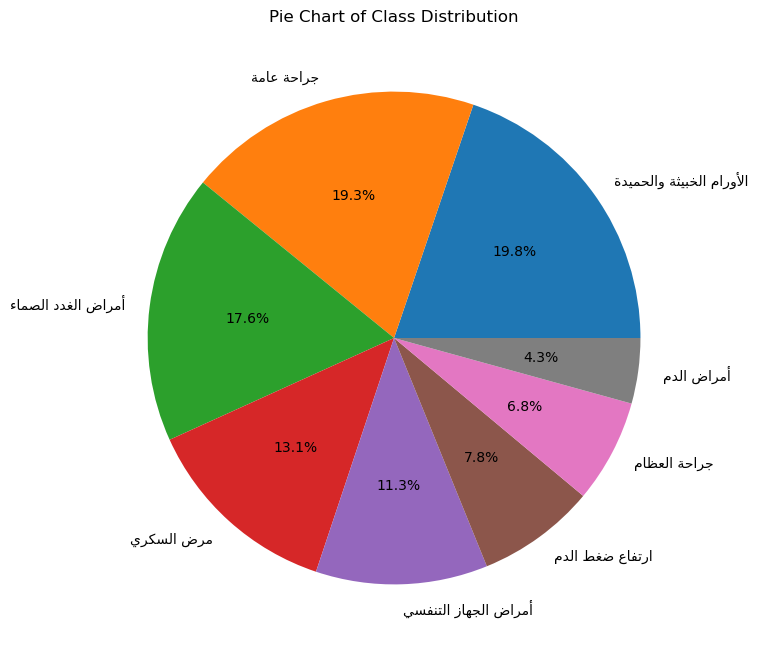

In [18]:
plt.rcParams['font.family'] = 'DejaVu Sans'

class_counts = train_df["label"].value_counts()
labels = class_counts.index

# Reshape Arabic labels for proper rendering
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=reshaped_labels, autopct="%1.1f%%")
plt.title("Pie Chart of Class Distribution")
plt.show()

## [2.2] 

In [19]:
tokenizer = TreebankWordTokenizer()
train_tokenized = pd.DataFrame()

train_tokenized['question'] = train_df['question'].apply(tokenizer.tokenize)
train_tokenized['answer'] = train_df['answer'].apply(tokenizer.tokenize)
train_tokenized['label'] = train_df['label']

train_tokenized.to_csv('train_tokenized.csv', index=False)

In [20]:
all_tokens = train_tokenized['question'] + train_tokenized['answer']

num_tokens = sum(len(tokens) for tokens in all_tokens)

print(f'Number of tokens in train data: {num_tokens}')

# Print the number of unique words (vocabulary)
vocab = set(word for tokens in all_tokens for word in tokens)
num_unique_words = len(vocab)

print(f'Number of unique words in train data: {num_unique_words}')

Number of tokens in train data: 2197088
Number of unique words in train data: 184167


## [2.3] 

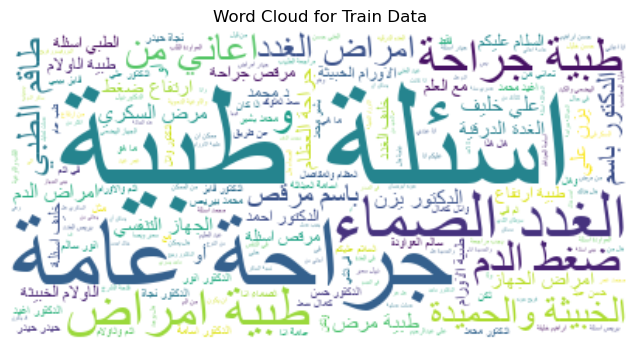

In [21]:
all_text_combined = ' '.join(' '.join(tokens) for tokens in all_tokens)

reshaped_text = arabic_reshaper.reshape(all_text_combined)
display_text = get_display(reshaped_text)

# Specify the path to the Arabic font on your system
arabic_font_path = r'C:\Windows\Fonts\arial.ttf'

wordcloud = WordCloud(font_path=arabic_font_path, background_color='white').generate(display_text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Train Data')
plt.show()

## [2.4] 

In [22]:
def analyze_text(tokens):

    word_freq = FreqDist(tokens)

    repeated_words = [word for word, freq in word_freq.most_common(15)]

    hapax_words = [word for word, freq in word_freq.items() if freq == 1][-10:]

    # Find repeated word pairs
    #finder = BigramCollocationFinder.from_words(tokens)
    #repeated_word_pairs = [bigram for bigram, freq in finder.ngram_fd.items()][:10]

    # Find repeated word triples  
    #finder = TrigramCollocationFinder.from_words(tokens)
    #repeated_word_triples = [trigram for trigram, freq in finder.ngram_fd.items()][:10]

    # Find repeated word pairs
    bigrams_list = list(bigrams(tokens))
    repeated_word_pairs = FreqDist(bigrams_list).most_common(10)
    
    # Find repeated word triples
    trigrams_list = list(trigrams(tokens))  # Rename the variable to trigrams_list
    repeated_word_triples = FreqDist(trigrams_list).most_common(10)
    
    # Find collocations (bigrams)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    collocations_finder = BigramCollocationFinder.from_words(tokens)
    collocations = collocations_finder.nbest(bigram_measures.pmi, 10)

    # Find collocations (trigrams)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigrams_finder = TrigramCollocationFinder.from_words(tokens)
    collocations2 = trigrams_finder.nbest(trigram_measures.pmi, 10)
    
    return {
        "Repeated Words": repeated_words,
        "Hapax Words": hapax_words,
        "Repeated Word Pairs": repeated_word_pairs,
        "Repeated Word Triples": repeated_word_triples,
        "Collocations (Bigrams)": collocations,
        "Collocations (Trigrams)": collocations2
    }

<div dir="rtl">يستخدم الكود المقدم مكتبة NLTK للعثور على ارتباطات الكلمات ذات المعنى (التجميعات) في مجموعة معينة من الرموز المميزة. يستخدم BigramCollocationFinder لأزواج الكلمات وTrigramCollocationFinder لتسلسلات من ثلاث كلمات. يتم استخدام مقياس المعلومات المتبادلة (PMI) لتقييم احتمالية حدوث الكلمات بشكل مشترك. يتم بعد ذلك اختيار أفضل 10 تجميعات بناءً على نتائج مؤشر مديري المشتريات (PMI)، مما يوفر نظرة ثاقبة حول ارتباطات الكلمات المهمة في النص . <div>

In [23]:
tokens = [token for sublist in train_tokenized['question'] + train_tokenized['answer'] for token in sublist]

analysis_result = analyze_text(tokens)
for category, result in analysis_result.items():
    print(f"{category}:\n{result}\n")

Repeated Words:
['الدكتور', 'من', 'في', 'و', '0', 'على', 'هل', 'لا', 'الدم', 'جراحة', 'د.', 'محمد', '1', 'مع', 'ان']

Hapax Words:
['تقرر.', 'كافياً.', 'قسوى', '07:36:20', '/اسئلة-طبية/الاورام-الخبيثة-والحميدة/علاج-سرطان-الثدى-المرحله-الثانيه-فى-احد-الممرات-tube-982701', 'و٧', 'مساميرفي', 'العضد.', 'الاثقال.', '/اسئلة-طبية/جراحة-العظام/تم-تركيب-شريحه-و٧-مساميرفي-العضد-التئم-الكسر-١٠٠٪-بعد-271390']

Repeated Word Pairs:
[(('جراحة', 'عامة'), 8322), (('طاقم', 'الطبي'), 5603), (('الغدد', 'الصماء'), 5488), (('الدكتور', 'باسم'), 5419), (('باسم', 'مرقص'), 5416), (('الدكتور', 'يزن'), 5298), (('يزن', 'علي'), 5296), (('علي', 'خليف'), 5296), (('السلام', 'عليكم'), 3973), (('امراض', 'الدم'), 3140)]

Repeated Word Triples:
[(('الدكتور', 'باسم', 'مرقص'), 5414), (('الدكتور', 'يزن', 'علي'), 5296), (('يزن', 'علي', 'خليف'), 5296), (('امراض', 'الدم', 'والاورام'), 3106), (('باسم', 'مرقص', 'جراحة'), 2707), (('مرقص', 'جراحة', 'عامة'), 2707), (('علي', 'خليف', 'الغدد'), 2648), (('خليف', 'الغدد', 'الصماء'), 264

In [24]:
tokenized_data = {}
for label, group in train_tokenized.groupby('label'):
    tokens = [token for sublist in group['question'] + group['answer'] for token in sublist]
    tokenized_data[label] = tokens
    
analysis_result = {}
for label, tokens in tokenized_data.items():
    result = analyze_text(tokens)
    analysis_result[label] = result

In [25]:
for label, result in analysis_result.items():
    print("-------------------------------------------------------------------------------------------------------------------")
    print(f"Label: \033[1m{label}\033[0m ")
    
    for category, result in result.items():
        print(f"{category}:\n{result}\n")

-------------------------------------------------------------------------------------------------------------------
Label: أمراض الجهاز التنفسي 
Repeated Words:
['من', 'في', 'الدكتور', 'و', '0', 'على', 'د.', 'صدرية', 'مع', 'هل', 'لا', 'او', 'التنفس', 'ان', 'محمد']

Hapax Words:
['والدموية.', '..وبالتالي', '19:13:42', '/اسئلة-طبية/امراض-الجهاز-التنفسي/لدي-صعوبة-التنفس-واعطس-كثيرا-و-كثيرا-ما-اصاب-بالزكام-529766', 'فاين', 'برنشيت', 'اللاستيروئيدية،', '2011-02-07', '14:56:59', '/اسئلة-طبية/امراض-الجهاز-التنفسي/اعاني-من-الام-في-الجانب-الايسر-في-منطقة-الثدي-وخاصة-34757']

Repeated Word Pairs:
[(('طاقم', 'الطبي'), 722), (('الدكتور', 'فايز'), 653), (('فايز', 'بيبي'), 651), (('اعاني', 'من'), 548), (('السلام', 'عليكم'), 462), (('في', 'التنفس'), 383), (('الجهاز', 'الهضمي'), 368), (('الحساسية', 'والمناعة'), 364), (('الدكتور', 'حسن'), 358), (('الهضمي', 'والكبد'), 344)]

Repeated Word Triples:
[(('الدكتور', 'فايز', 'بيبي'), 651), (('الجهاز', 'الهضمي', 'والكبد'), 344), (('فايز', 'بيبي', 'الجهاز'), 32

<div dir="rtl">بالطبع يوجد كلمات تميز كل صف وبالنسبة الى هل ثنائيات وثلاثيات الكلمات هي نفسها ال collocation فالجواب لا ممكن ان تكون كلمات مكررة كثيرا لكن ليس لها اي اهمية مثل تكرار كلمة the في اللغة الانكليزية ف هي مكررة بشكل كبير جدا ف هذا لا يعني انها مهمة في النص  <div>

## [2.5] 

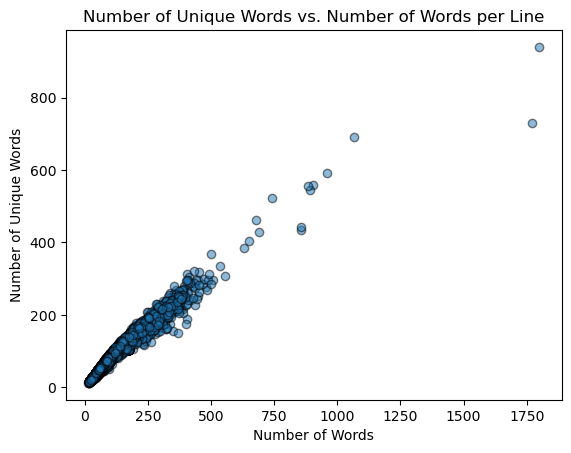

In [26]:
word_counts = [len(tokens) for tokens in all_tokens]
unique_word_counts = [len(set(tokens)) for tokens in all_tokens]

plt.scatter(word_counts, unique_word_counts, edgecolor='black', alpha=0.5)
plt.title('Number of Unique Words vs. Number of Words per Line')
plt.xlabel('Number of Words')
plt.ylabel('Number of Unique Words')
plt.show()

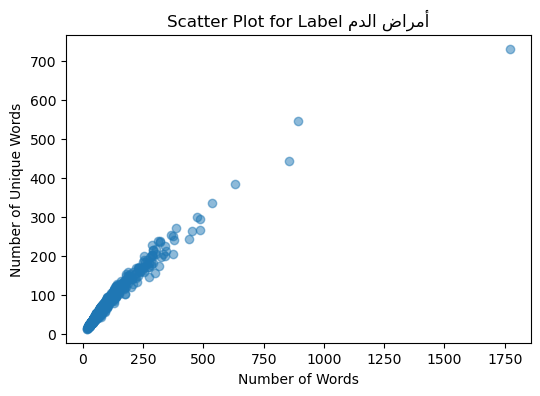

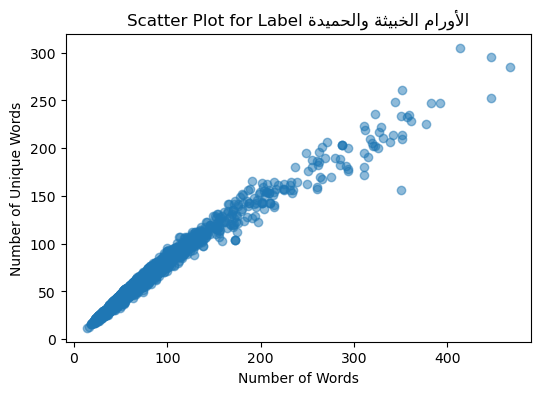

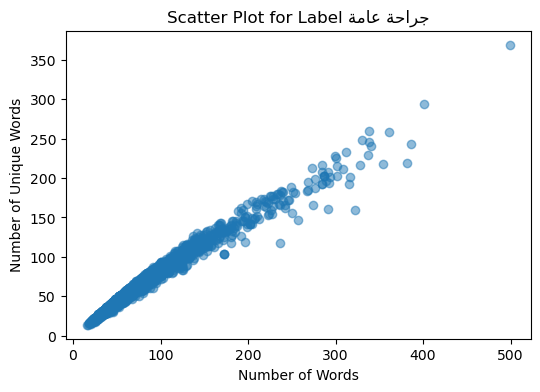

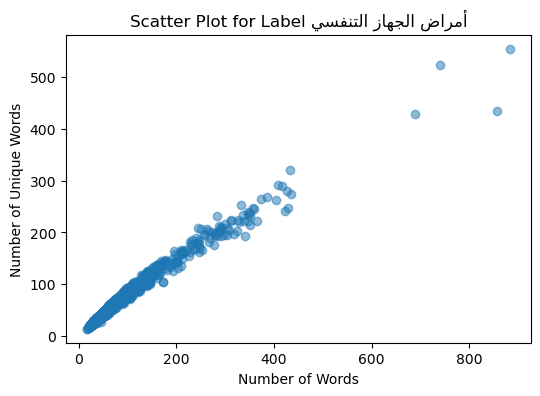

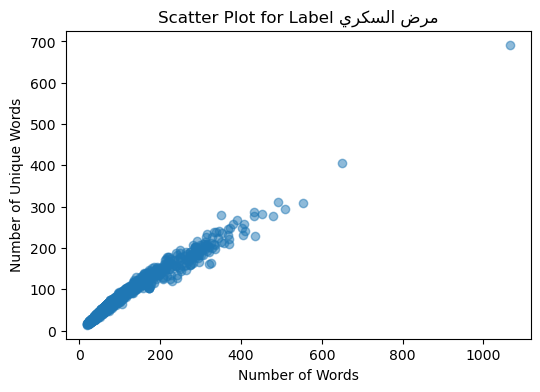

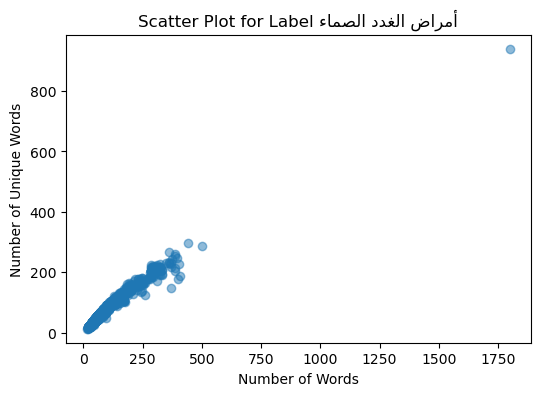

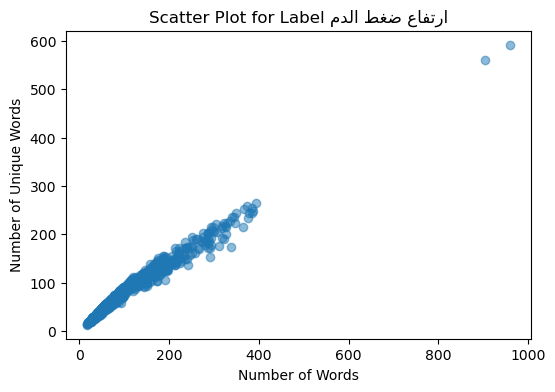

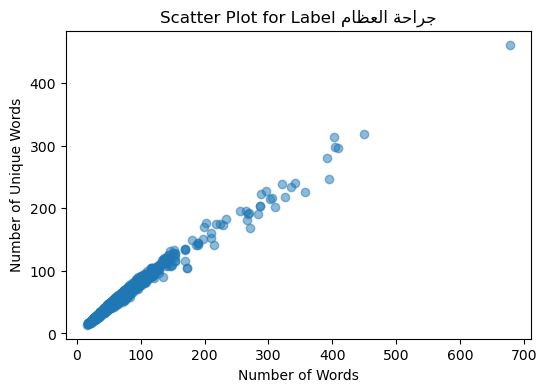

In [27]:
unique_labels = train_tokenized['label'].unique()

plt.rcParams['font.family'] = 'DejaVu Sans'

for label in unique_labels:
    label_data = train_tokenized[train_tokenized['label'] == label]
    word_counts = [len(tokens) for tokens in label_data['question'] + label_data['answer']]
    unique_word_counts = [len(set(tokens)) for tokens in label_data['question'] + label_data['answer']]
    
    reshaped_label = get_display(reshape(label))
    
    plt.figure(figsize=(6, 4))
    plt.scatter(word_counts, unique_word_counts, alpha=0.5)
    plt.title(f'Scatter Plot for Label {reshaped_label}')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Unique Words')
    plt.show()

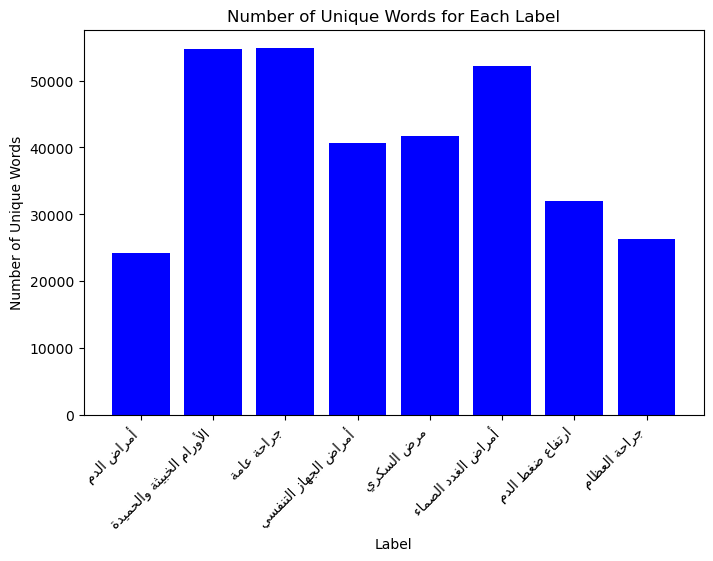

In [28]:
labels = train_tokenized['label'].unique()

label_names = []
num_unique_words_per_label = []

for label in labels:
    
    subset_df = train_tokenized[train_tokenized['label'] == label]
    all_tokens = subset_df['question'] + subset_df['answer']
    vocab = set(word for tokens in all_tokens for word in tokens)
    
    label_names.append(label)
    num_unique_words_per_label.append(len(vocab))

reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in label_names]

plt.figure(figsize=(8, 5))
plt.bar(reshaped_labels, num_unique_words_per_label, color='blue')
plt.xlabel('Label')
plt.ylabel('Number of Unique Words')
plt.title('Number of Unique Words for Each Label')
plt.xticks(rotation=45, ha='right')
plt.show()

<div dir="rtl">من خلال فحص الرسم البياني، يمكننا ملاحظة توزيع عدد الكلمات الفريدة عبر تسميات مختلفة.
تشير التسميات ذات الأشرطة الأعلى إلى مفردات أكبر أو نطاق أوسع من الكلمات الفريدة.
    والتي قد قد تشير إلى محتوى أكثر تنوعًا أو تعقيدًا.
قد تقترح التصنيفات التي تحتوي على عدد أقل من الكلمات الفريدة محتوى أكثر تركيزًا أو تكرارًا.<div>

# Text Cleaning and Normalization

## [3.1] 


In [18]:
def remove_links(text):
    
    link_pattern = r'(http|https)?://\S+|www\.\S+|\S+\.com\b'
    text_without_links = re.sub(link_pattern, '', text)

    return text_without_links

## [3.2] 

In [19]:
def remove_doctor_lines(text):
    # Define the patterns in Arabic
    patterns = [
        r'د\. ?',
        r'الدكتور',
        r'دكتور',
        r'بروفيسور',
        r'طاقم الطبي',
        r'الاستشاري'
    ]

    single_word_pattern = re.compile(fr'\b(?:{"|".join(patterns)})\b')

    lines = text.split('\n')

    after_pattern = False

    filtered_lines = []
    for line in lines:
        if single_word_pattern.search(line):
            after_pattern = True
            continue
        elif after_pattern and line.strip():
            after_pattern = False
            continue
        filtered_lines.append(line)

    result = '\n'.join(filtered_lines).strip()

    return result

## [3.3] 

In [21]:
def remove_duplicate_chars(input_string):
    pattern = re.compile(r'(.)\1{2,}')
    result = pattern.sub(r'\1\1', input_string)
    return result

## [3.4]

### [3.4.1] 

In [22]:
def switch_persian_to_english_numbers(input_string):
    persian_to_english_mapping = str.maketrans(
        "۰۱۲۳۴۵۶۷۸۹",
        "0123456789"
    )
    return input_string.translate(persian_to_english_mapping)

### [3.4.2] 

In [23]:
def number_to_emoji(number):
    number_emoji_mapping = {
        '0': '0️⃣',
        '1': '1️⃣',
        '2': '2️⃣',
        '3': '3️⃣',
        '4': '4️⃣',
        '5': '5️⃣',
        '6': '6️⃣',
        '7': '7️⃣',
        '8': '8️⃣',
        '9': '9️⃣',
        '٠': '0️⃣',
        '١': '1️⃣',
        '٢': '2️⃣',
        '٣': '3️⃣',
        '٤': '4️⃣',
        '٥': '5️⃣',
        '٦': '6️⃣',
        '٧': '7️⃣',
        '٨': '8️⃣',
        '٩': '9️⃣',
    }

    emoji_result = ''
    for digit in number:
        if digit in number_emoji_mapping:
            emoji_result += number_emoji_mapping[digit]
        else:
            emoji_result += digit

    return emoji_result

### [3.4.3] 

In [24]:
def remove_numbers(input_string):
    result = re.sub(r'\d', '', input_string)
    return result

### [3.4.4]

In [25]:
def remove_date_time(input_string):

    date_time_pattern = r'\b\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\b'
    result = re.sub(date_time_pattern, '', input_string)
    return result

## [3.5] 

### [3.5.1] 

In [26]:
def remove_punctuation(input_string):

    punctuation_pattern = r'[^\w\s]'
    result = re.sub(punctuation_pattern, '', input_string)
    return result

### [3.5.2] 

In [27]:
def remove_non_arabic_and_punctuation(input_string):

    non_arabic_and_punctuation_pattern = r'[^\u0600-\u06FF\.,;!()"\']'
    result = re.sub(non_arabic_and_punctuation_pattern, ' ', input_string)
    return result

## [3.6] 

In [28]:
stop_words = set(stopwords.words('arabic'))
custom_stop_words = {'اليعاذ','ايعاذ','عليكم', 'السلام','سلام','عليكم','رحمة','رحمه','الله','بالله','بركاته','إقرأ','مرحبا','مراحب','المزيد', 'أرجو', 'الرد'}
arabic_stop_words = stop_words.union(custom_stop_words)

def remove_stop_words_arabic(input_string):
    words = word_tokenize(input_string)
    filtered_words = [word for word in words if word.lower() not in arabic_stop_words]
    result = ' '.join(filtered_words)
    return result

## [3.7] 

In [29]:
def arabic_stemmer(word):
    
    prefixes = ['ا', 'ل', 'س', 'ت', 'ي', 'من']
    suffixes = ['ة', 'ه', 'ي', 'ت', 'ك', 'ن', 'ا', 'ون', 'ين', 'ات', 'ان', 'وا', 'يا', 'تم', 'هم', 'كم']

    for prefix in prefixes:
        if word.startswith(prefix):
            word = word[len(prefix):]

    for suffix in suffixes:
        if word.endswith(suffix):
            word = word[:-len(suffix)]

    return word

## [3.8] 

### [3.8.1] 

In [30]:
def replace_patterns(input_text):

    pattern1 = re.compile(r'[)ءؤئ(]')
    output_text = pattern1.sub('ء', input_text)
    pattern2 = re.compile(r'[)أآإ(]')
    output_text = pattern2.sub('ا', output_text)

    return output_text

### [3.8.2] 

In [32]:
def remove_tatweel(text):

    text = re.sub(r'(ـ{1,})', '', text)

    return text

### [3.8.3]

In [33]:
def remove_tashkeel(input_text):
    
    tashkeel_pattern = re.compile("[\u0617-\u061A\u064B-\u0652]+")
    output_text = tashkeel_pattern.sub("", input_text)
    
    return output_text

## [3.9] 

In [34]:
def remove_spaces_and_empty_lines(text):
    
    text = re.sub(r'\s', ' ', text)
    text = re.sub(r'^\s*$', ' ', text, flags=re.MULTILINE)

    return text

# Prepare Training Data

## [4.1] 


In [46]:
def global_processing_pipeline(text, processing_functions):
    processed_text = text
    
    for processing_function in processing_functions:
        processed_text = processing_function(processed_text)
    
    return processed_text

processing_functions = [
    remove_links,
    remove_doctor_lines,
    remove_duplicate_chars,
    number_to_emoji,
    switch_persian_to_english_numbers,
    remove_numbers,
    remove_date_time,
    remove_punctuation,
    remove_non_arabic_and_punctuation,
    remove_stop_words_arabic,
    arabic_stemmer,
    replace_patterns,
    remove_tatweel,
    remove_tashkeel,
    remove_spaces_and_empty_lines
]

In [47]:
x = train_df['answer'].head(5).apply(lambda x: global_processing_pipeline(x, processing_functions))

In [48]:
x.head(5).values

array(['كل علاج ايجابيته وسلبياته والتي تعتمد حالة المريض فما يناسب احدهم يناسب الاخر وهذا يحدده الطبيب خلال مراجعة المريض',
       'جب تخفيض الجرعة الا اذا سبب استءصال الغدة سرطان الغد',
       'فضل عدم الاستغناء العلاج الدواءي لمرضى الضغط يعد النظام الغذاءي الحركي اليومي للمريض جزء مهم اساسي الحفاظ ضغط المريض ضمن الحدود الطبيعية ينصح ممارسة دورية للرياضة المشي محاولة تخفيف الوزن التخفيف المنبهات بانواعها محاولة الاقلاع التدخين تناول الاطعمة الغنية بالبوتاسيوم كالموز تجنب الاطعمة تحتوي املاح لتاثيرها المباشر الضغط تناول المغذيات مستخلص الثوم زيوت السمك تجنب التوتر المحافظة نظام يومي هادء المتابعة الدورية لقراءات الضغط',
       'راجع طبيبك اجري الجراحه افضل يجيب لانه شاهد الحاله علي وضعها الاول وهوا بلفعل تمنياتي بلشفاء',
       'قصدت تدليك العضلة فهذا كلام صحيح ممارسة الرياضة المشي يعني حركة العضلات والمساهمة حرق السكر'],
      dtype=object)

## [4.2] 

In [49]:
train_cleaned = pd.DataFrame()

train_cleaned['question'] = train_df['question'].apply(lambda x: global_processing_pipeline(x, processing_functions))
train_cleaned['answer'] = train_df['answer'].apply(lambda x: global_processing_pipeline(x, processing_functions))
train_cleaned['label'] = train_df['label']

In [50]:
train_cleaned['question_tokenize'] = train_cleaned['question'].apply(tokenizer.tokenize)
train_cleaned['answer_tokenize'] = train_cleaned['answer'].apply(tokenizer.tokenize)

In [51]:
all_tokens = train_cleaned['question_tokenize'] + train_cleaned['answer_tokenize']

num_tokens = sum(len(tokens) for tokens in all_tokens)

print(f'Number of tokens in train data before cleaning data is \033[1m2197088\033[0m and after cleaning is: \033[1m{num_tokens}\033[0m')

# Print the number of unique words (vocabulary)
vocab = set(word for tokens in all_tokens for word in tokens) 
num_unique_words = len(vocab)

print(f'Number of unique words in train data before cleaning data is \033[1m184167\033[0m and after cleaning is: \033[1m{num_unique_words}\033[0m')

Number of tokens in train data before cleaning data is 2197088 and after cleaning is: 1287517
Number of unique words in train data before cleaning data is 184167 and after cleaning is: 84866


<div dir="rtl">أدت عملية التنظيف إلى تمثيل أكثر إيجازا وتركيزا لبيانات التدريب. يمكن أن يكون هذا مفيدا لأنه يساعد على تقليل التشويش وتحسين قدرة النموذج على تعميم الأنماط من البيانات.
    تعتبر خطوات المعالجة المسبقة هذه ضرورية لإنشاء مجموعة بيانات نظيفة وموحدة لتدريب النماذج .الهدف هو التركيز على المحتوى اللغوي ذي الصلة مع تقليل الضوضاء والاختلافات في البيانات.<div>

## [4.3] 

In [52]:
train_cleaned = train_cleaned.drop(['question_tokenize', 'answer_tokenize'], axis=1)

In [53]:
train_cleaned.shape[0]

32598

In [54]:
train_cleaned.head()

,question,answer,label
0,مميزات عيوب الدواء جلوكوفانس ايضا الانسولين مك...,كل علاج ايجابيته وسلبياته والتي تعتمد حالة الم...,أمراض الدم
1,ك نتيجة تحليل هرمونات الغدة الدرقية علما بانه ...,جب تخفيض الجرعة الا اذا سبب استءصال الغدة سرطا...,الأورام الخبيثة والحميدة
2,حلول منزلية لاعراض ارتفاع ضغط الدم,فضل عدم الاستغناء العلاج الدواءي لمرضى الضغط ي...,جراحة عامة
3,عملت عملية دوالي الساقين قسطرة الليزر شهر وعند...,راجع طبيبك اجري الجراحه افضل يجيب لانه شاهد ال...,أمراض الجهاز التنفسي
4,حقيقة ان تمرين العضلة النعلية يخفض السكر بالدم,قصدت تدليك العضلة فهذا كلام صحيح ممارسة الرياض...,مرض السكري


In [55]:
missing_values = train_cleaned.isnull().sum()

duplicates_count = train_cleaned.duplicated().sum()

print("\nNumber of null rows:", missing_values)
print("\nNumber of duplicate rows:", duplicates_count)


Number of null rows: question    0
answer      0
label       0
dtype: int64

Number of duplicate rows: 694


In [56]:
train_cleaned = train_cleaned.drop_duplicates()

In [57]:
train_cleaned['num_question_char'] = train_cleaned['question'].apply(lambda x: len(x))
train_cleaned['num_answer_char'] = train_cleaned['answer'].apply(lambda x: len(x))

rows_to_drop = train_cleaned[(train_cleaned['num_question_char'] <= 5) | (train_cleaned['num_answer_char'] <= 5)]

print(f"Number of rows with either question or answer having less than 5 characters: {len(rows_to_drop)}")

train_cleaned = train_cleaned[(train_cleaned['num_question_char'] > 5) & (train_cleaned['num_answer_char'] > 5)]

train_cleaned = train_cleaned.drop(['num_question_char', 'num_answer_char'], axis=1)

Number of rows with either question or answer having less than 5 characters: 1797


In [58]:
train_cleaned.shape[0]

30107

# Baseline

The Comparison Dictionary example

In [59]:
comparison_table = {}
comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['model_parameters'] = []
comparison_table['preprocessing_methods'] = []
comparison_table['accuracy'] = []
comparison_table['balance_accuracy'] = []

Filling the dictionary example

In [60]:
#comparison_table['question_step_number'].append("3.5")
#comparison_table['model_name'].append('logistic_regression')
#comparison_table['features'].append('bag of words')
#comparison_table['model_parameters'].append('default')
#comparison_table['preprocessing_methods'].append("remove links")
#comparison_table['accuracy'].append(accuracy)
#comparison_table['balance_accuracy'].append(balance_accuracy_value)

## [5.1]

In [35]:
X_train = train_df[['question', 'answer']]
y_train = train_df['label']

In [36]:
X_val = val_df[['question', 'answer']]
y_val = val_df['label']

In [37]:
X_test = test_df[['question', 'answer']]
y_test = test_df['label']

## [5.2]

In [38]:
def train_logistic_regression(X_train, y_train, X_test, y_test):

    combined_labels = pd.concat([y_train, y_test])

    label_encoder = LabelEncoder()
    combined_labels_encoded = label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    X_train['text'] = X_train['question'] + ' ' + X_train['answer'] #.fillna('')
    X_test['text'] = X_test['question'] + ' ' + X_test['answer']#.fillna('')

    vectorizer = CountVectorizer()
    X_train_bow = vectorizer.fit_transform(X_train['text'])
    X_test_bow = vectorizer.transform(X_test['text'])

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    model.fit(X_train_bow, y_train_encoded)

    y_test_pred_encoded = model.predict(X_test_bow)

    y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

    accuracy = accuracy_score(y_test, y_test_pred)
    balance_accuracy_value = balanced_accuracy_score(y_test, y_test_pred)

    return accuracy, balance_accuracy_value

In [65]:
accuracy, balance_accuracy_value = train_logistic_regression(X_train, y_train, X_test, y_test)

In [66]:
comparison_table['question_step_number'].append("5.2")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("non")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.2
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: non
accuracy: 0.6437
balance_accuracy: 0.6249


In [67]:
clear_session()

## [5.3]

In [68]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_links)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_links)),
    y_test
)

In [69]:
comparison_table['question_step_number'].append("5.3.1")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove links")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.1
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove links
accuracy: 0.6435
balance_accuracy: 0.6249


In [70]:
clear_session()

In [71]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_doctor_lines)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_doctor_lines)),
    y_test
)

In [72]:
comparison_table['question_step_number'].append("5.3.2")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove docotr name and specialization")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.2
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove docotr name and specialization
accuracy: 0.5231
balance_accuracy: 0.4977


In [73]:
clear_session()

In [74]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_duplicate_chars)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_duplicate_chars)),
    y_test
)

In [75]:
comparison_table['question_step_number'].append("5.3.3")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove duplicate chars")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.3
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove duplicate chars
accuracy: 0.6439
balance_accuracy: 0.6253


In [76]:
clear_session()

In [77]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(switch_persian_to_english_numbers)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(switch_persian_to_english_numbers)),
    y_test
)

In [78]:
comparison_table['question_step_number'].append("5.3.4")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("switch persian to english numbers")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.4
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: switch persian to english numbers
accuracy: 0.6437
balance_accuracy: 0.6249


In [79]:
clear_session()

In [80]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(number_to_emoji)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(number_to_emoji)),
    y_test
)

In [81]:
comparison_table['question_step_number'].append("5.3.5")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("switch numbers to emoji")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.5
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: switch numbers to emoji
accuracy: 0.6343
balance_accuracy: 0.6158


In [82]:
clear_session()

In [83]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_numbers)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_numbers)),
    y_test
)

In [84]:
comparison_table['question_step_number'].append("5.3.6")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove numbers")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.6
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove numbers
accuracy: 0.6346
balance_accuracy: 0.6157


In [85]:
clear_session()

In [86]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_date_time)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_date_time)),
    y_test
)

In [87]:
comparison_table['question_step_number'].append("5.3.7")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove date time")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.7
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove date time
accuracy: 0.6438
balance_accuracy: 0.6250


In [88]:
clear_session()

In [89]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_punctuation)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_punctuation)),
    y_test
)

In [90]:
comparison_table['question_step_number'].append("5.3.8")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove punctuation")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.8
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove punctuation
accuracy: 0.5963
balance_accuracy: 0.5738


In [91]:
clear_session()

In [92]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_non_arabic_and_punctuation)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_non_arabic_and_punctuation)),
    y_test
)

In [93]:
comparison_table['question_step_number'].append("5.3.9")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove non arabic and punctuation")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.9
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove non arabic and punctuation
accuracy: 0.6342
balance_accuracy: 0.6153


In [94]:
clear_session()

In [95]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_stop_words_arabic)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_stop_words_arabic)),
    y_test
)

In [96]:
comparison_table['question_step_number'].append("5.3.10")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove arabic stop words")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.10
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove arabic stop words
accuracy: 0.6460
balance_accuracy: 0.6265


In [97]:
clear_session()

In [98]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(arabic_stemmer)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(arabic_stemmer)),
    y_test
)

In [99]:
comparison_table['question_step_number'].append("5.3.11")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("arabic stemmer")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.11
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: arabic stemmer
accuracy: 0.6437
balance_accuracy: 0.6249


In [100]:
clear_session()

In [101]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(replace_patterns)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(replace_patterns)),
    y_test
)

In [102]:
comparison_table['question_step_number'].append("5.3.12")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("replace patterns")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.12
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: replace patterns
accuracy: 0.6415
balance_accuracy: 0.6233


In [103]:
clear_session()

In [104]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_tatweel)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_tatweel)),
    y_test
)

In [105]:
comparison_table['question_step_number'].append("5.3.13")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove tatweel")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.13
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove tatweel
accuracy: 0.6439
balance_accuracy: 0.6252


In [106]:
clear_session()

In [107]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_tashkeel)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_tashkeel)),
    y_test
)

In [108]:
comparison_table['question_step_number'].append("5.3.14")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove tashkeel")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.14
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove tashkeel
accuracy: 0.6424
balance_accuracy: 0.6234


In [109]:
clear_session()

In [110]:
accuracy, balance_accuracy_value = train_logistic_regression(
    X_train[['question', 'answer']].apply(lambda x: x.apply(remove_spaces_and_empty_lines)),
    y_train,
    X_test[['question', 'answer']].apply(lambda x: x.apply(remove_spaces_and_empty_lines)),
    y_test
)

In [111]:
comparison_table['question_step_number'].append("5.3.15")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("remove spaces and empty lines")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number: 5.3.15
model_name: logistic_regression
features: bag of words
model_parameters: default
preprocessing_methods: remove spaces and empty lines
accuracy: 0.6437
balance_accuracy: 0.6249


In [131]:
clear_session()

## [5.4]

In [38]:
def processing_pipeline(text, processing_functions):
    processed_text = text
    
    for processing_function in processing_functions:
        processed_text = processing_function(processed_text)
    
    return processed_text

processing_functions = [
    remove_links,
    remove_duplicate_chars,
    switch_persian_to_english_numbers,
    remove_date_time,
    remove_stop_words_arabic,
    arabic_stemmer,
    remove_tatweel,
    remove_tashkeel,
    remove_spaces_and_empty_lines
]

In [39]:
X_train.loc[:, 'question'] = X_train['question'].apply(lambda x: processing_pipeline(x, processing_functions)) #copy warning
X_train.loc[:, 'answer'] = X_train['answer'].apply(lambda x: processing_pipeline(x, processing_functions))

In [40]:
X_test.loc[:, 'question'] = X_test['question'].apply(lambda x: processing_pipeline(x, processing_functions))
X_test.loc[:, 'answer'] = X_test['answer'].apply(lambda x: processing_pipeline(x, processing_functions))

In [41]:
X_val.loc[:, 'question'] = X_val['question'].apply(lambda x: processing_pipeline(x, processing_functions))
X_val.loc[:, 'answer'] = X_val['answer'].apply(lambda x: processing_pipeline(x, processing_functions))

In [77]:
Concatenated = pd.DataFrame()

Concatenated['text'] = pd.concat([X_train['question'], X_train['answer']], axis=1).apply(lambda x: ''.join(x), axis=1)
Concatenated['label'] = y_train

Concatenated.to_csv('train_Concatenated.csv', index=False)

In [48]:
accuracy, balance_accuracy_value = train_logistic_regression( X_train[['question', 'answer']], y_train,
                                                              X_test[['question', 'answer']], y_test)

In [49]:
comparison_table['question_step_number'].append("5.4")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("processing function")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number                     5.4
model_name               logistic_regression
features                        bag of words
model_parameters                     default
preprocessing_methods    processing function
accuracy                            0.648112
balance_accuracy                    0.628964
Name: 0, dtype: object


## [5.5]

In [50]:
def train_logistic_regression_tfidf(X_train, y_train, X_test, y_test):
    combined_labels = pd.concat([y_train, y_test])

    label_encoder = LabelEncoder()
    combined_labels_encoded = label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    X_train['text'] = X_train['question'] + ' ' + X_train['answer']
    X_test['text'] = X_test['question'] + ' ' + X_test['answer']

    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train['text'])
    X_test_tfidf = vectorizer.transform(X_test['text'])

    model = LogisticRegression()  # Using default parameters
    model.fit(X_train_tfidf, y_train_encoded)

    y_test_pred_encoded = model.predict(X_test_tfidf)

    y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

    accuracy = accuracy_score(y_test, y_test_pred)
    balance_accuracy_value = balanced_accuracy_score(y_test, y_test_pred)

    return accuracy, balance_accuracy_value

In [51]:
accuracy, balance_accuracy_value = train_logistic_regression_tfidf( X_train[['question', 'answer']], y_train,
                                                                    X_test[['question', 'answer']], y_test)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
comparison_table['question_step_number'].append("5.5")
comparison_table['model_name'].append('logistic_regression')
comparison_table['features'].append('bag of words') # sorry it should print(tfidf)
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("processing function")
comparison_table['accuracy'].append(accuracy)
comparison_table['balance_accuracy'].append(balance_accuracy_value)

last_index = len(comparison_table['accuracy']) - 1
for key in comparison_table.keys():
    value = "{:.4f}".format(comparison_table[key][last_index]) if key in ['accuracy', 'balance_accuracy'] else comparison_table[key][last_index]
    print(f"{key}: {value}")

question_step_number                           5.4
model_name               logistic_regression_tfidf
features                              bag of words
model_parameters                           default
preprocessing_methods          processing function
accuracy                                  0.702978
balance_accuracy                          0.687528
Name: 0, dtype: object


## [5.6]

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd

def train_logistic_regression_tfidf(X_train, y_train, X_val, y_val, X_test, y_test):
    # Combine training and validation data
    combined_data = pd.concat([X_train, X_val])
    combined_labels = pd.concat([y_train, y_val])

    # Encode labels
    label_encoder = LabelEncoder()
    combined_labels_encoded = label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    # Combine text for TF-IDF vectorization
    combined_data['text'] = combined_data['question'] + ' ' + combined_data['answer']

    # Fine-tune TF-IDF parameters on combined training and validation data
    vectorizer = TfidfVectorizer()  # You can specify parameters here
    X_combined_tfidf = vectorizer.fit_transform(combined_data['text'])

    # Split the combined TF-IDF data back into training and validation parts
    X_train_tfidf, X_val_tfidf = X_combined_tfidf[:len(X_train)], X_combined_tfidf[len(X_train):]

    # Train logistic regression model on the updated training data
    model = LogisticRegression()  # Using default parameters
    model.fit(X_train_tfidf, y_train_encoded)

    # Predict on validation data
    y_val_pred_encoded = model.predict(X_val_tfidf)
    y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

    # Evaluate on validation data
    accuracy_val = accuracy_score(y_val, y_val_pred)
    balance_accuracy_val = balanced_accuracy_score(y_val, y_val_pred)

    # Use the tuned TF-IDF vectorizer to transform the test data
    X_test['text'] = X_test['question'] + ' ' + X_test['answer']
    X_test_tfidf = vectorizer.transform(X_test['text'])

    # Predict on test data
    y_test_pred_encoded = model.predict(X_test_tfidf)
    y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

    # Evaluate on test data
    accuracy_test = accuracy_score(y_test, y_test_pred)
    balance_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)

    return accuracy_val, balance_accuracy_val, accuracy_test, balance_accuracy_test

In [47]:
val_accuracy, val_balance_accuracy, test_accuracy, test_balance_accuracy = train_logistic_regression_tfidf(
    X_train[['question', 'answer']], y_train,
    X_val[['question', 'answer']], y_val,
    X_test[['question', 'answer']], y_test
)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
comparison_table = pd.DataFrame({
    'question_step_number': ["5.6"],
    'model_name': ['logistic_regression_tfidf_finetune'],
    'features': ['bag of words'], # sorry it should be tfidf
  #  'model_parameters': [f'TF-IDF: {best_params["tfidf"]}, Logistic Regression: C={best_params["logisticregression__C"]}'],
    'preprocessing_methods': ["processing function"],
    'accuracy': [val_accuracy],
    'balance_accuracy': [val_balance_accuracy],
    'test accuracy': [test_accuracy],
    'test balance_accuracy': [test_balance_accuracy]  
})

print("Validation Results:")
for index, row in comparison_table.iterrows():
    print(row)

Validation Results:
question_step_number                                    5.4
model_name               logistic_regression_tfidf_finetune
features                                       bag of words
preprocessing_methods                   processing function
accuracy                                           0.704964
balance_accuracy                                   0.691957
test accuracy                                      0.702092
test balance_accuracy                              0.686405
Name: 0, dtype: object


# Semantic Representation

## [6.1]

In [56]:
def get_word_frequency_array(texts, target_word):

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    
    feature_names = vectorizer.get_feature_names_out()
    
    if target_word not in feature_names:
        print(f"The word '{target_word}' is not present in the texts.")
        return
    
    # Get the index for the target word
    word_index = np.where(feature_names == target_word)[0][0]
    
    # Get the word frequency vector for the target word
    word_frequency = X[:, word_index].toarray().flatten()
    
    return word_frequency

In [57]:
target_word = "تحليل"

print(f"Word Frequency Array for '{target_word}' is : {get_word_frequency_array(Concatenated['text'], target_word)}") 

Word Frequency Array for 'تحليل' is : [0 2 0 ... 0 0 0]


## [6.2]

In [70]:
def get_top_words_in_context(texts, target_word, window_size=1, top_n=25):
    # Get word frequency array using the get_word_frequency_array function
    word_frequency = get_word_frequency_array(texts, target_word)

    # Find the indices of non-zero occurrences of the target word
    non_zero_indices = np.where(word_frequency > 0)[0]

    # Initialize a dictionary to store word frequencies in the context
    context_word_frequencies = {}

    # Initialize the CountVectorizer (if you still need it for some reason)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Get the context indices outside the loop
    context_indices = np.concatenate([
        np.arange(max(0, i - window_size), min(len(feature_names), i + window_size + 1))
        for i in non_zero_indices
    ])

    # Remove the target word index from the context indices
    context_indices = np.setdiff1d(context_indices, np.where(feature_names == target_word)[0][0])

    # Iterate over the non-zero indices to get context word frequencies
    for index in non_zero_indices:
        # Get the context word frequencies
        context_word_frequencies_in_doc = X[index, context_indices].toarray().flatten()

        # Update the dictionary with context word frequencies
        for i, context_index in enumerate(context_indices):
            context_word = feature_names[context_index]
            frequency = context_word_frequencies_in_doc[i]
            context_word_frequencies[context_word] = context_word_frequencies.get(context_word, 0) + frequency

    # Sort the dictionary by frequencies in descending order
    sorted_context_word_frequencies = sorted(context_word_frequencies.items(), key=lambda x: x[1], reverse=True)

    # Print the top N words
    print(f"Top {top_n} words in the context of '{target_word}':")
    for i, (word, frequency) in enumerate(sorted_context_word_frequencies[:top_n]):
        print(f"{i + 1}. {word}: {frequency}")

In [80]:
target_word = "دم"
get_top_words_in_context(X_train['question'], target_word, window_size=1, top_n=25)

Top 25 words in the context of 'دم':
1. الشرج: 166
2. اعاني: 106
3. الدكتور: 76
4. العلم: 62
5. الان: 48
6. تعاني: 47
7. الام: 42
8. الضغط: 42
9. الصدر: 39
10. اعرف: 37
11. بسبب: 37
12. الحل: 31
13. اخذ: 24
14. المنطقة: 18
15. الي: 18
16. العمليه: 15
17. تاني: 14
18. الظهر: 13
19. انو: 13
20. بوجود: 12
21. بينزل: 12
22. 80: 11
23. الرقبة: 11
24. امراض: 10
25. احمرار: 9


## [6.3]

In [98]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
import string
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, Reshape, dot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np

# Constants
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 10000
BATCH_SIZE = 1024
SEED = 42

# Assuming you have a DataFrame named Concatenated with 'text' and 'label' columns

# Text preprocessing function
def custom_standardization(input_text):
    lowercase_text = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase_text, f'[{re.escape(string.punctuation)}]', '')
    return cleaned_text

# Assuming you have defined the generate_training_data function
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []

    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    for sequence in tqdm.tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        for target_word, context_word in positive_skip_grams:
            target_word = np.array(target_word)  # Convert to NumPy array
            context_word = np.array(context_word)  # Convert to NumPy array

            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling"
            )

            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(tf.squeeze(context, axis=1))  # Fix: Remove unnecessary axis
            labels.append(label)

    return targets, contexts, labels

# Step 1: Tokenize and Vectorize the Text Data
vocab_size = len(set(" ".join(Concatenated['text']).split()))
sequence_length = 10

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)
vectorize_layer.adapt(Concatenated['text'].values)

# Step 2: Generate Skip-grams
targets, contexts, labels = generate_training_data(vectorize_layer(Concatenated['text'].values), window_size=2, num_ns=4, vocab_size=vocab_size, seed=SEED)

# Step 3: Train Word2Vec Model
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                                embedding_dim,
                                                input_length=1,
                                                name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                                 embedding_dim,
                                                 input_length=5)  # num_ns + 1

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        return dots

embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

word2vec.fit(dataset, epochs=10)

100%|████████████████████████████████████████████████████████████████████████████| 32598/32598 [10:26<00:00, 52.01it/s]


Epoch 1/10
435/435 [==============================] - 252s 573ms/step - loss: 1.5171 - accuracy: 0.3626
Epoch 2/10
435/435 [==============================] - 250s 575ms/step - loss: 1.1818 - accuracy: 0.5702
Epoch 3/10
435/435 [==============================] - 237s 544ms/step - loss: 0.9611 - accuracy: 0.6523
Epoch 4/10
435/435 [==============================] - 244s 562ms/step - loss: 0.7699 - accuracy: 0.7608
Epoch 5/10
435/435 [==============================] - 236s 543ms/step - loss: 0.5938 - accuracy: 0.8522
Epoch 6/10
435/435 [==============================] - 236s 542ms/step - loss: 0.4432 - accuracy: 0.9136
Epoch 7/10
435/435 [==============================] - 240s 552ms/step - loss: 0.3236 - accuracy: 0.9504
Epoch 8/10
435/435 [==============================] - 242s 555ms/step - loss: 0.2341 - accuracy: 0.9705
Epoch 9/10
435/435 [==============================] - 253s 583ms/step - loss: 0.1699 - accuracy: 0.9819
Epoch 10/10
435/435 [==============================] - 242s 556m

## [6.4]

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


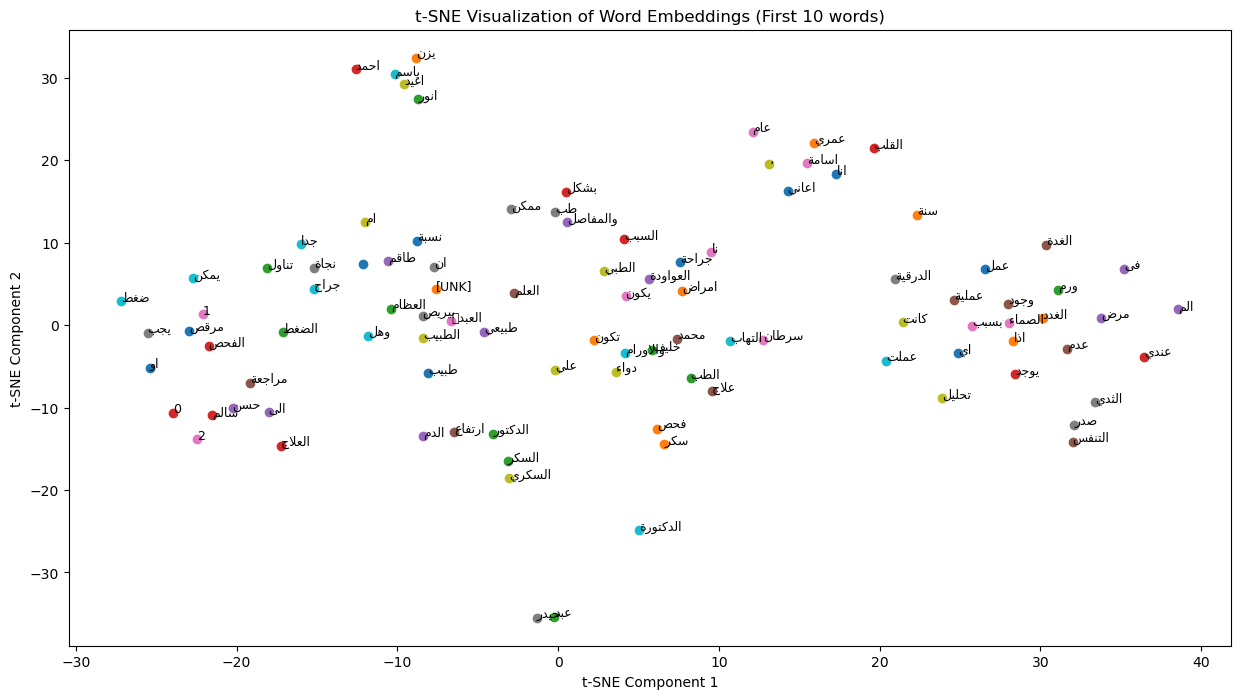

In [139]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import arabic_reshaper
from bidi.algorithm import get_display

# Your existing code for obtaining word embeddings

# Select the first 10 words and their embeddings
selected_words = vectorize_layer.get_vocabulary()[:100]
selected_indices = [vectorize_layer.get_vocabulary().index(word) for word in selected_words]
selected_embeddings = word_embeddings[selected_indices]

# Perform t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=3, random_state=SEED)  # Adjust perplexity as needed
selected_embeddings_tsne = tsne.fit_transform(selected_embeddings)

# Plot the t-SNE embeddings with Arabic text
plt.figure(figsize=(15, 8))
for i, word in enumerate(selected_words):
    x, y = selected_embeddings_tsne[i, :]
    reshaped_word = arabic_reshaper.reshape(word)
    bidi_text = get_display(reshaped_word)
    
    plt.scatter(x, y)
    plt.text(x, y, bidi_text, fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings (First 10 words)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## [6.5]

In [147]:
def analogy_operation(model, word1, word2, word3):
    try:
        # Get word vectors for the given words
        vec1 = model.target_embedding(tf.constant([[vectorize_layer.get_vocabulary().index(word1)]]))
        vec2 = model.target_embedding(tf.constant([[vectorize_layer.get_vocabulary().index(word2)]]))
        vec3 = model.target_embedding(tf.constant([[vectorize_layer.get_vocabulary().index(word3)]]))

        # Reshape the vectors
        vec1 = tf.reshape(vec1, [1, -1])
        vec2 = tf.reshape(vec2, [1, -1])
        vec3 = tf.reshape(vec3, [1, -1])

        # Perform analogy operation
        result_vector = vec2 - vec1 + vec3

        # Find the closest word to the result vector
        result_word_index = tf.argmax(tf.reshape(result_vector, [-1]))
        result_word = vectorize_layer.get_vocabulary()[result_word_index]


        return result_word

    except KeyError as e:
        return f"Error: {e} not found in the vocabulary."

# Example usage
#for i in range(5):
word1 = "مريض"
word2 = "دكتور"
word3 = "دم"
    
result = analogy_operation(word2vec, word1, word2, word3)
print(f"{word1} is to {word2} as {word3} is to {result}")

مريض is to دكتور as دم is to اخذ


# Deep Neural Network

### [7.1.1]

In [191]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def BOW(X_train, y_train, X_val, y_val, max_features=100, epochs=10, batch_size=32):
    # Extract 'question' and 'answer' columns
    X_train_text = X_train['question'] + ' ' + X_train['answer']
    X_val_text = X_val['question'] + ' ' + X_val['answer']

    # Convert string labels to numeric values
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)

    # Convert labels to one-hot encoding for multi-class classification
    y_train_categorical = to_categorical(y_train_encoded, num_classes=len(np.unique(y_train)))
    y_val_categorical = to_categorical(y_val_encoded, num_classes=len(np.unique(y_train)))

    # Create bag-of-words representation with reduced vocabulary size
    vectorizer = CountVectorizer(max_features=max_features)

    # Convert sparse matrix to dense matrix and then apply lowercase transformation
    X_train_dense = vectorizer.fit_transform(X_train_text).toarray()
    X_val_dense = vectorizer.transform(X_val_text).toarray()

    # Build the neural network model for multi-class classification
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_dense.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compile the model with categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_dense, y_train_categorical, epochs=epochs, batch_size=batch_size,
              validation_data=(X_val_dense, y_val_categorical), callbacks=[early_stopping])

    return model

In [192]:
model = BOW(X_train, y_train, X_val, y_val, max_features=100, epochs=10, batch_size=32)

Epoch 1/10
1019/1019 [==============================] - 9s 7ms/step - loss: 1.8638 - accuracy: 0.6452 - val_loss: 1.3618 - val_accuracy: 0.7027
Epoch 2/10
1019/1019 [==============================] - 7s 6ms/step - loss: 1.3222 - accuracy: 0.7265 - val_loss: 1.3041 - val_accuracy: 0.7046
Epoch 3/10
1019/1019 [==============================] - 7s 7ms/step - loss: 1.2883 - accuracy: 0.7295 - val_loss: 1.2858 - val_accuracy: 0.7069
Epoch 4/10
1019/1019 [==============================] - 8s 7ms/step - loss: 1.2739 - accuracy: 0.7313 - val_loss: 1.2751 - val_accuracy: 0.7083
Epoch 5/10
1019/1019 [==============================] - 9s 9ms/step - loss: 1.2628 - accuracy: 0.7326 - val_loss: 1.2711 - val_accuracy: 0.7067
Epoch 6/10
1019/1019 [==============================] - 7s 7ms/step - loss: 1.2546 - accuracy: 0.7324 - val_loss: 1.2665 - val_accuracy: 0.7069
Epoch 7/10
1019/1019 [==============================] - 11s 10ms/step - loss: 1.2471 - accuracy: 0.7332 - val_loss: 1.2635 - val_accurac

### [7.1.2]

In [42]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def tfidf_(X_train, y_train, X_val, y_val, max_features=100, epochs=10, batch_size=32):
    # Extract 'question' and 'answer' columns
    X_train_text = X_train['question'] + ' ' + X_train['answer']
    X_val_text = X_val['question'] + ' ' + X_val['answer']

    # Convert string labels to numeric values
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)

    # Convert labels to one-hot encoding for multi-class classification
    y_train_categorical = to_categorical(y_train_encoded, num_classes=len(np.unique(y_train)))
    y_val_categorical = to_categorical(y_val_encoded, num_classes=len(np.unique(y_train)))

    # Create TF-IDF representation with reduced vocabulary size
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Convert sparse matrix to dense matrix
    X_train_tfidf = vectorizer.fit_transform(X_train_text).toarray()
    X_val_tfidf = vectorizer.transform(X_val_text).toarray()

    # Build the neural network model for multi-class classification
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compile the model with categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_tfidf, y_train_categorical, epochs=epochs, batch_size=batch_size,
              validation_data=(X_val_tfidf, y_val_categorical), callbacks=[early_stopping])

    return model

In [43]:
model_tfidf = tfidf_(X_train, y_train, X_val, y_val, max_features=100, epochs=10, batch_size=32)

Epoch 1/10
1019/1019 [==============================] - 5s 3ms/step - loss: 1.7742 - accuracy: 0.6003 - val_loss: 1.4918 - val_accuracy: 0.6780
Epoch 2/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.4600 - accuracy: 0.6899 - val_loss: 1.4371 - val_accuracy: 0.6788
Epoch 3/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.4183 - accuracy: 0.6950 - val_loss: 1.4046 - val_accuracy: 0.6798
Epoch 4/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.3887 - accuracy: 0.6997 - val_loss: 1.3818 - val_accuracy: 0.6911
Epoch 5/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.3672 - accuracy: 0.7040 - val_loss: 1.3693 - val_accuracy: 0.6913
Epoch 6/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.3578 - accuracy: 0.7087 - val_loss: 1.3608 - val_accuracy: 0.6932
Epoch 7/10
1019/1019 [==============================] - 3s 3ms/step - loss: 1.3409 - accuracy: 0.7138 - val_loss: 1.3570 - val_accuracy: